### Setup

In [3]:
import os
os.chdir("../../quantum_eigenfaces/package/")
import IPython

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [6]:

from tqdm import tqdm
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from quantum_eigenfaces.epsilon_tuning import epsilon_tuning 
from quantum_eigenfaces.utils.utils import DataSplit, TrainingConfig, TuningConfig

### Load MNIST Dataset

In [7]:
import joblib
memory_mnist = joblib.Memory('./tmp_mnist')
fetch_openml_cached_mnist = memory_mnist.cache(fetch_openml)

X, y = fetch_openml_cached_mnist('mnist_784', version=1, return_X_y=True)  

n_labels = len(set(y))

train_val_test = [0.70,0.15,0.15]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_val_test[2], random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=train_val_test[1]/(1-train_val_test[2]), random_state=1)

tot = len(X_train) + len(X_val) + len(X_test) 
print(f"Datapoints number: {tot}")
print(f"Classes number: {n_labels}")
print(f"Training set: {len(X_train)/tot}")
print(f"Validation set: {len(X_val)/tot}")
print(f"Test set: {len(X_test)/tot}")


X_train = X_train.to_numpy()
X_valid = X_val.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy().astype(int)
y_valid = y_val.to_numpy().astype(int)
y_test = y_test.to_numpy().astype(int)



________________________________________________________________________________
[Memory] Calling sklearn.datasets._openml.fetch_openml...
fetch_openml('mnist_784', version=1, return_X_y=True)


/Users/chattershuts/Desktop/GitHub/quantum-eigenfaces/.venv/lib/python3.9/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


____________________________________________________fetch_openml - 24.6s, 0.4min
Datapoints number: 70000
Classes number: 10
Training set: 0.7
Validation set: 0.15
Test set: 0.15


### Load Outliers: Fashion MNIST

In [8]:

import joblib
memory = joblib.Memory('./tmp')
fetch_openml_cached = memory.cache(fetch_openml)

X, y = fetch_openml_cached(data_id=40996, return_X_y=True) # Fashion MNIST


n_labels = len(set(y))

train_val_test = [0.70,0.05,0.05]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=train_val_test[2], random_state=1)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=train_val_test[1]/(1-train_val_test[2]), random_state=1)



tot = len(X_train2) + len(X_val2) + len(X_test2) 
print(f"Datapoints number: {tot}")
print(f"Classes number: {n_labels}")
print(f"Training set: {len(X_train2)/tot}")
print(f"Validation set: {len(X_val2)/tot}")
print(f"Test set: {len(X_test2)/tot}")


________________________________________________________________________________
[Memory] Calling sklearn.datasets._openml.fetch_openml...
fetch_openml(data_id=40996, return_X_y=True)


/Users/chattershuts/Desktop/GitHub/quantum-eigenfaces/.venv/lib/python3.9/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


____________________________________________________fetch_openml - 25.2s, 0.4min
Datapoints number: 70000
Classes number: 10
Training set: 0.8999857142857143
Validation set: 0.05001428571428571
Test set: 0.05


### Combine datasets and show split shapes

In [9]:

X_valid_wa = np.concatenate([X_valid, X_val2.to_numpy()])
y_valid_wa = np.concatenate([[int(y) for y in y_valid], [-1 for _ in range(len(X_val2))]])
X_test_wa = np.concatenate([X_test, X_test2.to_numpy()])
y_test_wa = np.concatenate([[int(y) for y in y_test], [-1 for _ in range(len(X_test2))]])



### Normalization

In [10]:
X_train_n = X_train / 255
X_valid_n = X_valid / 255
X_valid_wa_n = X_valid_wa / 255
X_test_n = X_test / 255
X_test_wa_n = X_test_wa / 255

In [12]:
print(f"X_train_n:    {X_train_n.shape}")
print(f"y_train:      {y_train.shape}")
print("------------------------")
print(f"X_valid_n:    {X_valid_n.shape}")
print(f"y_valid:      {y_valid.shape}")
print(f"X_valid_wa_n: {X_valid_wa_n.shape}")
print(f"y_valid_wa:   {y_valid_wa.shape}")
print("------------------------")
print(f"X_test_n:     {X_test_n.shape}")
print(f"y_test:       {y_test.shape}")
print(f"X_test_wa_n:  {X_test_wa_n.shape}")
print(f"y_test_wa:    {y_test_wa.shape}")

X_train_n:    (49000, 784)
y_train:      (49000,)
------------------------
X_valid_n:    (10500, 784)
y_valid:      (10500,)
X_valid_wa_n: (14001, 784)
y_valid_wa:   (14001,)
------------------------
X_test_n:     (10500, 784)
y_test:       (10500,)
X_test_wa_n:  (14000, 784)
y_test_wa:    (14000,)


### Formalize dataset splits and fitting configurations

In [13]:

datasplit_without_outliers = DataSplit(X_train=X_train_n, 
                                       y_train=y_train, 
                                       X_valid=X_valid_n, 
                                       y_valid=y_valid, 
                                       X_test=X_test_n, 
                                       y_test=y_test)

datasplit_with_outliers = DataSplit(X_train=X_train_n, 
                                    y_train=y_train, 
                                    X_valid=X_valid_wa_n, 
                                    y_valid=y_valid_wa, 
                                    X_test=X_test_wa_n, 
                                    y_test=y_test_wa)

training_config = TrainingConfig(n_components=60)
tuning_config = TuningConfig(tot_num_of_deltas=1600)



___________________________________
## Classical Algorithm  

### $\delta_1= \infty$;  Norm Threshold = False; Outliers = False 

In [31]:
np.random.seed(0)
summary1 = epsilon_tuning(datasplit=datasplit_without_outliers, 
               training_config=training_config, 
               tuning_config=tuning_config,
               reshaper=(28,28),
               epsilons=[0.0],
               xi=0,
               use_norm_threshold=False,
               num_iterations=1,
               delta1=10000,
                        visuals=False) 


********* TRAINING **************
Normalization Threshold is: 0.746925
********* TUNING **************
delta1 has been chosen by the user. No delta1 tuning is performed.
_______
Epsilon: 0.0
Compute predictions...
The norm threshold is not going to be used.
********* TESTING **************


Avg Accuracy: 0.975047619047619
Avg Accuracy Train: 0.975047619047619
Avg Recall: 0.0


In [32]:
summary1

,epsilon,Accuracy,Accuracy Train,False Acceptance Rate,False Recognition Rate,Precision,Recall,F1-Score,Stddev Accuracy,Stddev Accuracy Train,Stddev False Acceptance Rate,Stddev False Recognition Rate,Stddev Precision,Stddev Recall,Stddev F1-Score
0,0.0,0.975048,0.975048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### $\delta_1= tuned$;  Norm Threshold = False; Outliers = True 

In [35]:
np.random.seed(0)
summary2 = epsilon_tuning(datasplit=datasplit_with_outliers, 
                training_config=training_config, 
                tuning_config=tuning_config,
                reshaper=(28,28),
                epsilons=[0.0],
                xi=0,
                use_norm_threshold=False,
                delta1=22.26,
                num_iterations=1)


********* TRAINING **************
Normalization Threshold is: 0.746925
********* TUNING **************
delta1 has been chosen by the user. No delta1 tuning is performed.
_______
Epsilon: 0.0
Compute predictions...
The norm threshold is not going to be used.
********* TESTING **************


Avg Accuracy: 0.9060714285714285
Avg Accuracy Train: 0.9404761904761905
Avg Recall: 0.8028571428571428


In [36]:
summary2 

,epsilon,Accuracy,Accuracy Train,False Acceptance Rate,False Recognition Rate,Precision,Recall,F1-Score,Stddev Accuracy,Stddev Accuracy Train,Stddev False Acceptance Rate,Stddev False Recognition Rate,Stddev Precision,Stddev Recall,Stddev F1-Score
0,0.0,0.906071,0.940476,0.049286,0.031286,0.865148,0.802857,0.832839,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### $\delta_1= tuned$;  Norm Threshold = True; Outliers = True 

In [37]:
np.random.seed(0)
summary3 = epsilon_tuning(datasplit=datasplit_with_outliers, 
                          training_config=training_config, 
                          tuning_config=tuning_config,
                          reshaper=(28,28),
                          epsilons=[0.0],
                          xi=0,
                          use_norm_threshold=True,
                          num_iterations=1,
                          visuals=False,
                          delta1=22.26) 

********* TRAINING **************
Normalization Threshold is: 0.746925
********* TUNING **************
delta1 has been chosen by the user. No delta1 tuning is performed.
_______
Epsilon: 0.0
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.9267142857142857
Avg Accuracy Train: 0.9404761904761905
Avg Recall: 0.8854285714285715


In [38]:
summary3

,epsilon,Accuracy,Accuracy Train,False Acceptance Rate,False Recognition Rate,Precision,Recall,F1-Score,Stddev Accuracy,Stddev Accuracy Train,Stddev False Acceptance Rate,Stddev False Recognition Rate,Stddev Precision,Stddev Recall,Stddev F1-Score
0,0.0,0.926714,0.940476,0.028643,0.031286,0.876166,0.885429,0.880773,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Quantum 

### $\delta_1= tuned$;  Norm Threshold = True; Outliers = True

In [61]:
np.random.seed(0)
epsilons_domain = np.arange(0, 90, 5) 
summary4 = epsilon_tuning(datasplit=datasplit_with_outliers, 
                                training_config=training_config, 
                                tuning_config=tuning_config,
                                reshaper=(28,28),
                                epsilons=epsilons_domain,
                                use_norm_threshold=True,
                                num_iterations=100,
                                delta1=22.339989,
                                ds_name="MNIST",
                                compute_runtimes=False)


********* TRAINING **************
Normalization Threshold is: 0.749187
********* TUNING **************
delta1 has been chosen by the user. No delta1 tuning is performed.
_______
Epsilon: 0
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.927227857142857
Avg Accuracy Train: 0.9405714285714288
Avg Recall: 0.8871971428571429
_______
Epsilon: 5
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.9259735714285714
Avg Accuracy Train: 0.9430304761904763
Avg Recall: 0.8748028571428573
_______
Epsilon: 10
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.9225357142857143
Avg Accuracy Train: 0.9492542857142855
Avg Recall: 0.84238
_______
Epsilon: 15
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.912825
Avg Accuracy Train: 0.9489419047619049
Avg Recall: 0.8044742857142857
_______
Epsilon: 20
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8967192857142858
Avg Accuracy Train: 0.9405171428571428
Avg Recall: 0.7653257142857144
_______
Epsilon: 25
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8739099999999997
Avg Accuracy Train: 0.9220304761904763
Avg Recall: 0.7295485714285713
_______
Epsilon: 30
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8449428571428572
Avg Accuracy Train: 0.8941809523809522
Avg Recall: 0.6972285714285714
_______
Epsilon: 35
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8097542857142858
Avg Accuracy Train: 0.8559514285714287
Avg Recall: 0.6711628571428573
_______
Epsilon: 40
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.7711407142857144
Avg Accuracy Train: 0.810838095238095
Avg Recall: 0.6520485714285713
_______
Epsilon: 45
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.728797857142857
Avg Accuracy Train: 0.7584961904761904
Avg Recall: 0.6397028571428571
_______
Epsilon: 50
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.683932142857143
Avg Accuracy Train: 0.7009466666666667
Avg Recall: 0.6328885714285714
_______
Epsilon: 55
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.638962857142857
Avg Accuracy Train: 0.6423990476190476
Avg Recall: 0.6286542857142856
_______
Epsilon: 60
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.5942257142857144
Avg Accuracy Train: 0.583532380952381
Avg Recall: 0.6263057142857142
_______
Epsilon: 65
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.5514271428571428
Avg Accuracy Train: 0.5269771428571428
Avg Recall: 0.6247771428571428
_______
Epsilon: 70
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.5111057142857143
Avg Accuracy Train: 0.47341809523809514
Avg Recall: 0.6241685714285715
_______
Epsilon: 75
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.474165
Avg Accuracy Train: 0.4243085714285714
Avg Recall: 0.6237342857142857
_______
Epsilon: 80
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.44157071428571437
Avg Accuracy Train: 0.38076952380952384
Avg Recall: 0.6239742857142858
_______
Epsilon: 85
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.41181571428571423
Avg Accuracy Train: 0.34104571428571423
Avg Recall: 0.6241257142857143


In [65]:
summary4.head()

,epsilon,Accuracy,Accuracy Train,False Acceptance Rate,False Recognition Rate,Precision,Recall,F1-Score,Stddev Accuracy,Stddev Accuracy Train,Stddev False Acceptance Rate,Stddev False Recognition Rate,Stddev Precision,Stddev Recall,Stddev F1-Score
0,0,0.927228,0.940571,0.028201,0.031143,0.876877,0.887197,0.882007,0.000202,2.220446e-16,0.000202,0.000000,0.000098,0.000807,0.000448
1,5,0.925974,0.943030,0.031299,0.024301,0.900002,0.874803,0.887221,0.001048,1.191229e-03,0.000512,0.000583,0.002189,0.002046,0.001629
2,10,0.922536,0.949254,0.039405,0.013201,0.941016,0.842380,0.888967,0.001386,1.423104e-03,0.000651,0.000566,0.002402,0.002604,0.001937
3,15,0.912825,0.948942,0.048881,0.006354,0.969381,0.804474,0.879258,0.001353,1.390991e-03,0.000794,0.000422,0.001952,0.003177,0.001963
4,20,0.896719,0.940517,0.058669,0.002722,0.985975,0.765326,0.861744,0.001614,1.677989e-03,0.000985,0.000314,0.001591,0.003939,0.002539


In [68]:
summary4

,epsilon,Accuracy,Accuracy Train,False Acceptance Rate,False Recognition Rate,Precision,Recall,F1-Score,Stddev Accuracy,Stddev Accuracy Train,Stddev False Acceptance Rate,Stddev False Recognition Rate,Stddev Precision,Stddev Recall,Stddev F1-Score
0,0,0.927228,0.940571,0.028201,0.031143,0.876877,0.887197,0.882007,0.000202,2.220446e-16,0.000202,0.000000,0.000098,0.000807,0.000448
1,5,0.925974,0.943030,0.031299,0.024301,0.900002,0.874803,0.887221,0.001048,1.191229e-03,0.000512,0.000583,0.002189,0.002046,0.001629
2,10,0.922536,0.949254,0.039405,0.013201,0.941016,0.842380,0.888967,0.001386,1.423104e-03,0.000651,0.000566,0.002402,0.002604,0.001937
3,15,0.912825,0.948942,0.048881,0.006354,0.969381,0.804474,0.879258,0.001353,1.390991e-03,0.000794,0.000422,0.001952,0.003177,0.001963
4,20,0.896719,0.940517,0.058669,0.002722,0.985975,0.765326,0.861744,0.001614,1.677989e-03,0.000985,0.000314,0.001591,0.003939,0.002539
5,25,0.873910,0.922030,0.067613,0.000964,0.994742,0.729549,0.841747,0.001797,2.030331e-03,0.000909,0.000177,0.000958,0.003637,0.002391
6,30,0.844943,0.894181,0.075693,0.000249,0.998572,0.697229,0.821121,0.001953,2.578913e-03,0.000859,0.000113,0.000649,0.003436,0.002416
7,35,0.809754,0.855951,0.082209,0.000040,0.999762,0.671163,0.803148,0.001892,2.518269e-03,0.000775,0.000049,0.000290,0.003100,0.002212
8,40,0.771141,0.810838,0.086988,0.000005,0.999969,0.652049,0.789368,0.002470,3.125928e-03,0.000763,0.000018,0.000112,0.003053,0.002235
9,45,0.728798,0.758496,0.090074,0.000000,1.000000,0.639703,0.780264,0.002416,3.200745e-03,0.000632,0.000000,0.000000,0.002529,0.001880


In [69]:
def find_highest_acceptable_epsilon(summary):
    starting_accuracy = summary.loc[0, "Accuracy"]
    print(starting_accuracy)
    accuracy_threshold = starting_accuracy * 0.975
    print(accuracy_threshold)
    highest_acceptable_epsilon = summary["epsilon"][summary["Accuracy"] >= accuracy_threshold][-1:].values[0]
    return highest_acceptable_epsilon

highest_acceptable_epsilon = find_highest_acceptable_epsilon(summary4__)
highest_acceptable_epsilon

0.927227857142857
0.9040471607142856


15

In [71]:
import matplotlib.pyplot as plt
import matplotlib
def plot_metrics_at_varying_epsilon(results: pd.DataFrame, name: str, epsilon_domain: list[float], logx: bool = False, tick_step: int = 1):
    
    fontsize = 60
    legend_fontsize = 48
    matplotlib.rcParams.update({'font.size': fontsize})

    
    epsilons = results["epsilon"].values
    acc = results["Accuracy"].values
    stddev_acc = results["Stddev Accuracy"].values
    stddev_acc_train = results["Stddev Accuracy Train"].values
    stddev_recall = results["Stddev Recall"].values
    stddev_f1 = results["Stddev F1-Score"].values
    stddev_prec = results["Stddev Precision"].values
    
    acc_train = results["Accuracy Train"].values
    prec = results["Precision"].values
    rec = results["Recall"].values
    f1 = results["F1-Score"].values

    if logx:
        epsilons = [np.log10(epsilon) for epsilon in epsilons]
        epsilon_domain = [np.log10(epsilon) for epsilon in epsilon_domain]
        xlabel = "$\log{\epsilon}}$"
    else:
        xlabel = "$\epsilon$"

    # Set the figure size
    plt.figure(figsize=(20, 10))

    # ------------ First graph -------------
    #plt.subplot(2, 1, 1)
    
    # Accuracy
    plt.plot(epsilons, acc, label='Accuracy')
    plt.fill_between(epsilons, acc-stddev_acc, acc+stddev_acc, color="lightskyblue")

    # Accuracy Train
    plt.plot(epsilons, acc_train, label='Main Accuracy')
    plt.fill_between(epsilons, acc_train-stddev_acc_train, acc_train+stddev_acc_train, color="wheat")
    
    # Recall 
    plt.plot(epsilons, rec, label='Recall')
    plt.fill_between(epsilons, rec-stddev_recall, rec+stddev_recall, color="mediumaquamarine")
    
    plt.legend(fontsize=legend_fontsize, framealpha=1)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel('Metrics', fontsize=fontsize)
    plt.xticks(epsilon_domain[0:-1:tick_step])
    plt.grid(True)
    
    file_name = f"{name}_epsilon_wrt_acc_train_and_recall.pdf"
    plt.savefig(file_name, bbox_inches='tight')
    print(f"Saved plot at {file_name}")
    plt.show()
    plt.clf()
    
    # ------------ Second Graph -------------
    
    plt.figure(figsize=(20, 10))

    #plt.subplot(2, 1, 2)
    # F1 Score
    plt.plot(epsilons, f1, label='F1 Score')
    plt.fill_between(epsilons, f1-stddev_f1, f1+stddev_f1, color="lightskyblue")
    
    # Precision
    plt.plot(epsilons, prec, label='Precision')
    plt.fill_between(epsilons, prec-stddev_prec, prec+stddev_prec, color="wheat")

    
    # Recall
    plt.plot(epsilons, rec, label='Recall')
    plt.fill_between(epsilons, rec-stddev_recall, rec+stddev_recall, color="mediumaquamarine")

    
    plt.legend(fontsize=legend_fontsize, loc='upper right', bbox_to_anchor=(1.00, 0.95), framealpha=0.5)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel('Metrics', fontsize=fontsize)
    plt.xticks(epsilon_domain[0:-1:tick_step])

    plt.grid(True)
    file_name = f"{name}_epsilon_wrt_pre_rec_and_f1.pdf"
    plt.savefig(file_name, bbox_inches='tight')
    print(f"Saved plot at {file_name}")



Saved plot at MNIST_epsilon_wrt_acc_train_and_recall.pdf


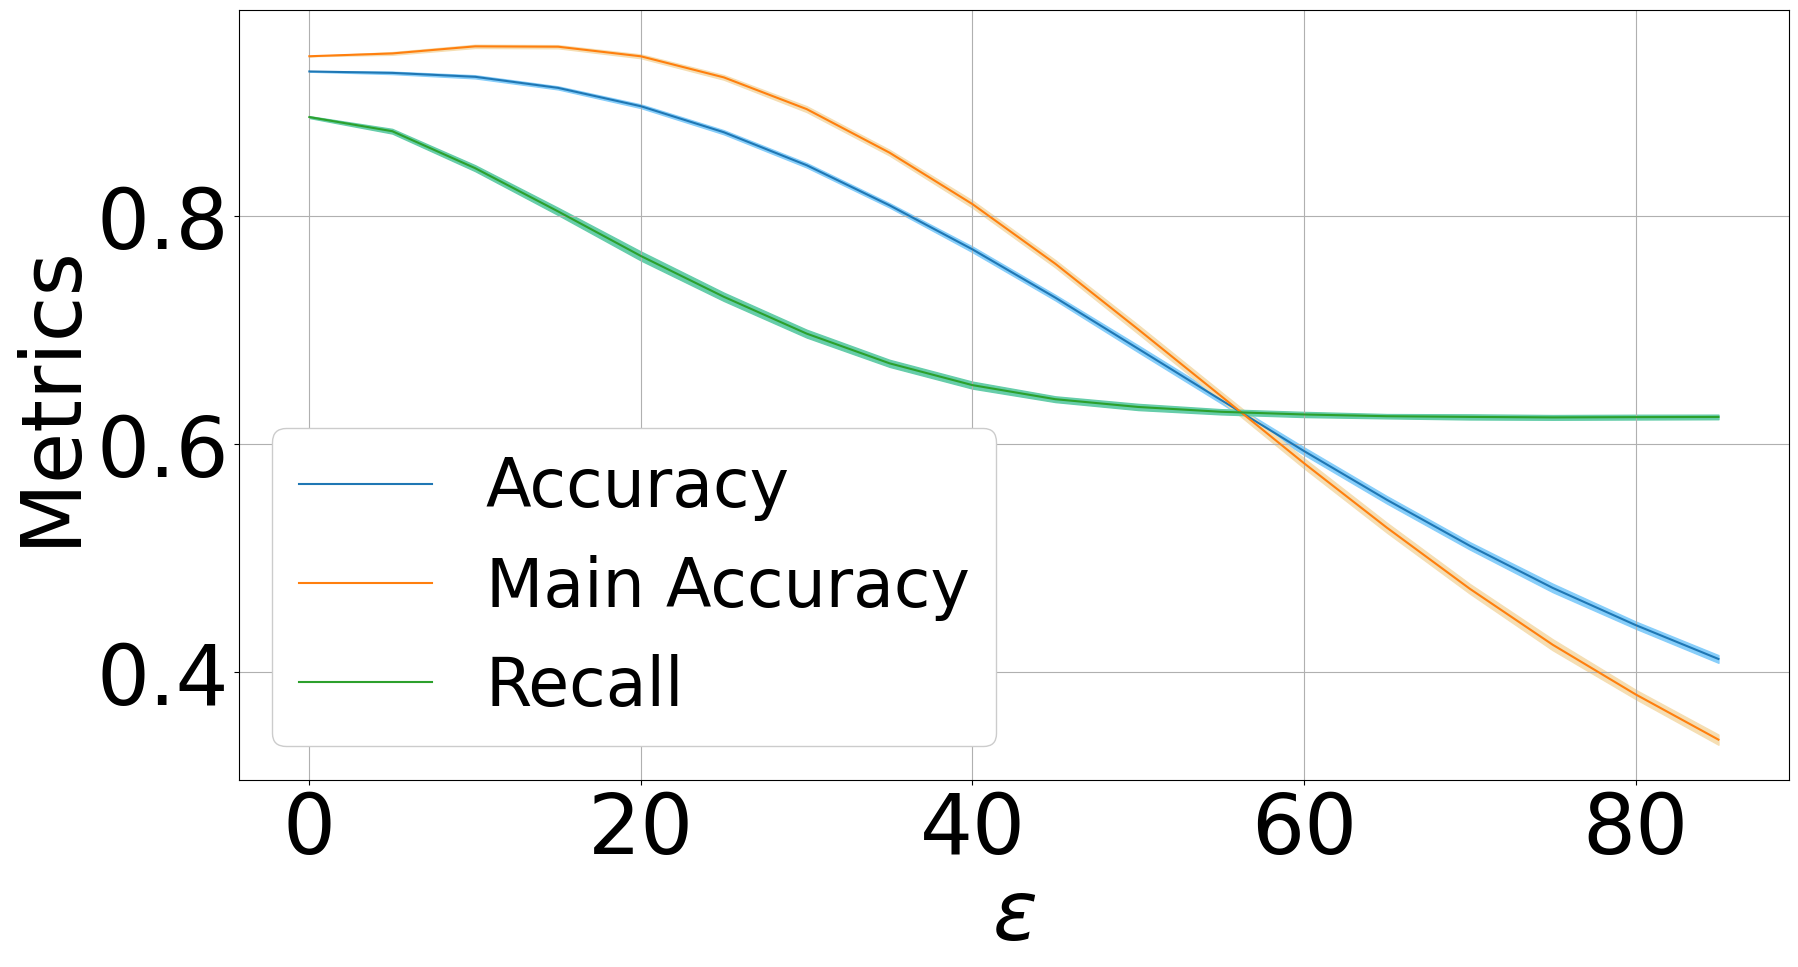

Saved plot at MNIST_epsilon_wrt_pre_rec_and_f1.pdf


<Figure size 640x480 with 0 Axes>

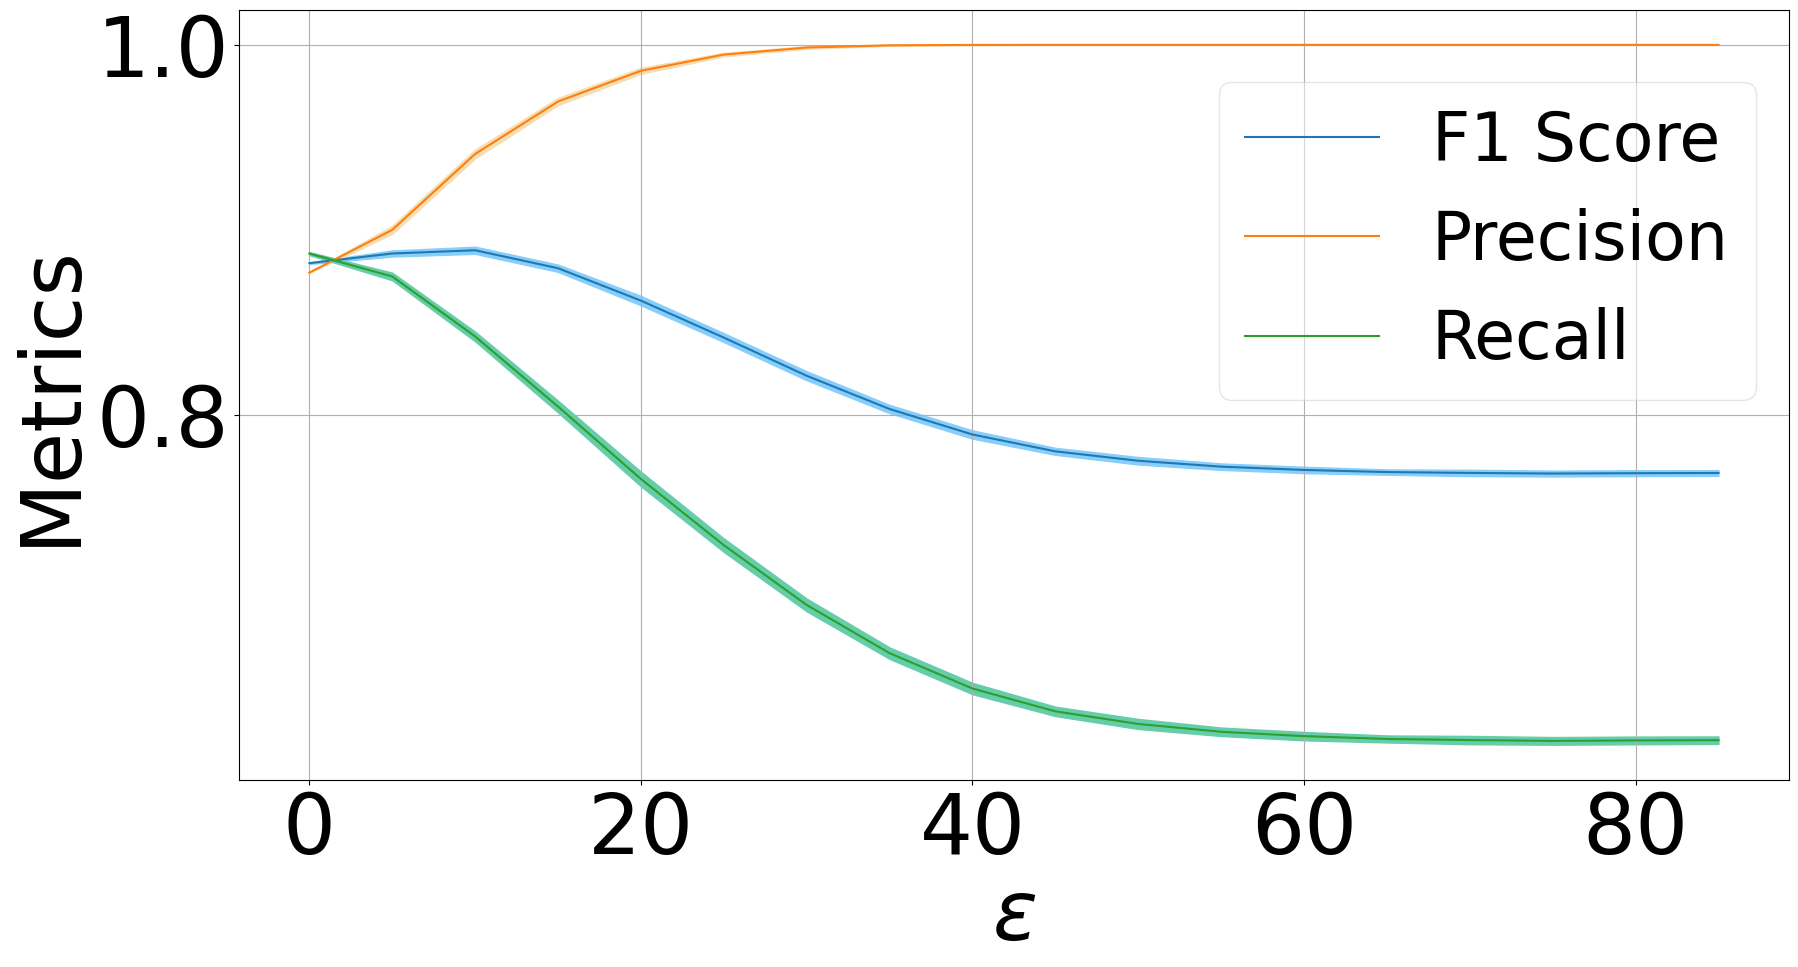

In [73]:
# from quantum_eigenfaces.utils.visualization import plot_metrics_at_varying_epsilon
plot_metrics_at_varying_epsilon(summary4__, "MNIST", epsilon_domain=epsilons_domain, tick_step=4)